In [1]:
import numpy as np
import os
import pickle

my_dir = '../soap/average'
files = np.sort(os.listdir(my_dir))
gb_list = []
for file in files:
    with open(my_dir+'/'+file,'rb') as f:
        data = pickle.load(f)
        gb_list.append(data)

energy = np.load('../sample_energy.npy')

In [2]:
print(f'(Number of grain boundaries,length of SOAP representation): {np.shape(gb_list)}')
print(f'length of energies: {len(energy)}')

(Number of grain boundaries,length of SOAP representation): (10, 1014)
length of energies: 10


In [3]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score

# Data
X = np.array(gb_list)
y = energy

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of lambda values to try
lambdas = np.logspace(-3.5, 2.5, 60)

# Tolerance for considering coefficients as zero
tolerance = 1e-5

# List to keep track of the number of non-zero coefficients
non_zero_counts = []
costs = []
r2_scores = []
image_of_nonzero_params = np.zeros((np.shape(X)[1],len(lambdas)))
# Loop over the lambda values
for i,l in enumerate(lambdas):
    # Create and fit the Lasso model
    model = Lasso(alpha=l)
    model.fit(X_scaled, y)

    # Count the number of non-zero coefficients (considering the tolerance)
    image_of_nonzero_params[:,i] = np.abs(model.coef_) > tolerance
    non_zero_count = np.sum(np.abs(model.coef_) > tolerance)
    non_zero_counts.append(non_zero_count)
    y_pred = model.predict(X_scaled)
    costs.append(np.linalg.norm(y_pred-y))
    r2_scores.append(r2_score(y, y_pred))


# Output the lambda values and corresponding non-zero counts
for l, count in zip(lambdas, non_zero_counts):
    print(f"Lambda: {l:.2e}, Non-Zero Coefficients: {count}")



/home/cbo27/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e+00, tolerance: 2.164e+00
  model = cd_fast.enet_coordinate_descent(
/home/cbo27/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.061e+00, tolerance: 2.164e+00
  model = cd_fast.enet_coordinate_descent(
/home/cbo27/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.186e+

Lambda: 3.16e-04, Non-Zero Coefficients: 755
Lambda: 4.00e-04, Non-Zero Coefficients: 723
Lambda: 5.05e-04, Non-Zero Coefficients: 669
Lambda: 6.38e-04, Non-Zero Coefficients: 630
Lambda: 8.07e-04, Non-Zero Coefficients: 591
Lambda: 1.02e-03, Non-Zero Coefficients: 552
Lambda: 1.29e-03, Non-Zero Coefficients: 519
Lambda: 1.63e-03, Non-Zero Coefficients: 480
Lambda: 2.06e-03, Non-Zero Coefficients: 464
Lambda: 2.60e-03, Non-Zero Coefficients: 395
Lambda: 3.29e-03, Non-Zero Coefficients: 356
Lambda: 4.16e-03, Non-Zero Coefficients: 345
Lambda: 5.25e-03, Non-Zero Coefficients: 328
Lambda: 6.64e-03, Non-Zero Coefficients: 278
Lambda: 8.39e-03, Non-Zero Coefficients: 252
Lambda: 1.06e-02, Non-Zero Coefficients: 244
Lambda: 1.34e-02, Non-Zero Coefficients: 222
Lambda: 1.69e-02, Non-Zero Coefficients: 206
Lambda: 2.14e-02, Non-Zero Coefficients: 197
Lambda: 2.71e-02, Non-Zero Coefficients: 150
Lambda: 3.42e-02, Non-Zero Coefficients: 130
Lambda: 4.32e-02, Non-Zero Coefficients: 120
Lambda: 5.

In [4]:
tolerance = 0.04
indices = np.argwhere(np.isclose(r2_scores,0.439, atol=tolerance)).flatten()

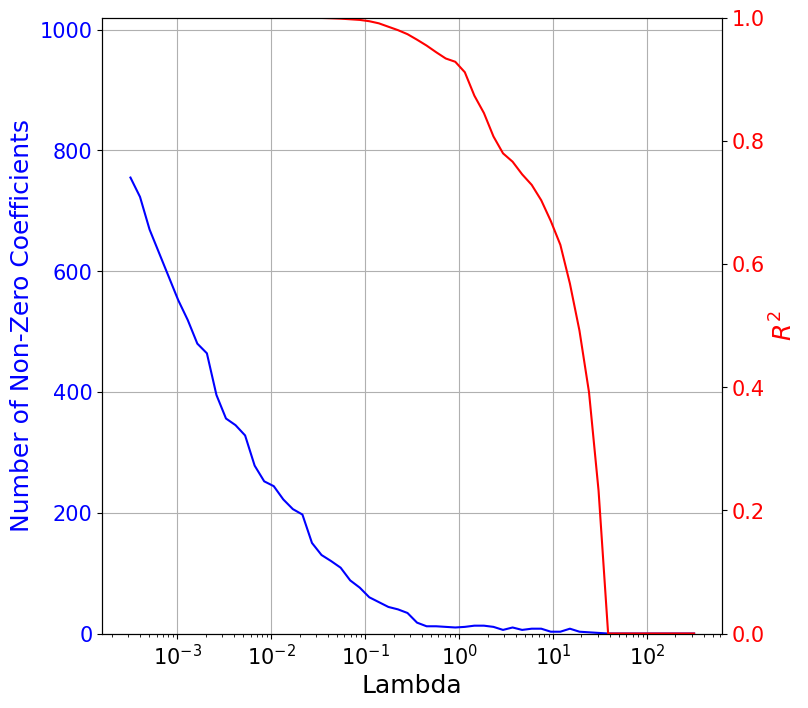

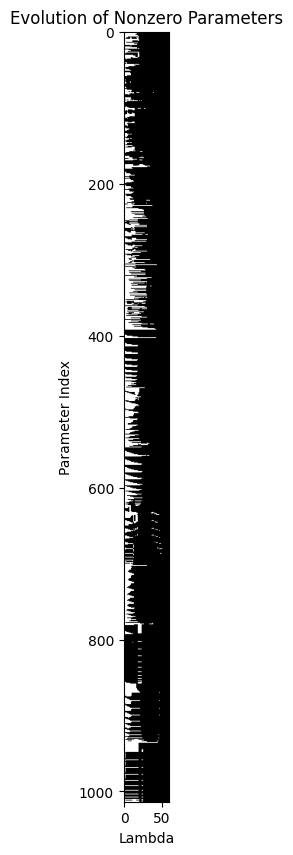

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

fig, ax1 = plt.subplots(figsize=(8, 8))

# First y-axis (left)
ax1.set_xlabel('Lambda',fontsize=18)
ax1.set_xscale('log')
ax1.set_ylim(0,1020)
ax1.set_ylabel('Number of Non-Zero Coefficients', color='blue',fontsize=18)
ax1.plot(lambdas, non_zero_counts, color='blue')
ax1.tick_params(axis='y', labelcolor='blue',labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
plt.grid()

# Second y-axis (right)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_xscale('log')
ax2.set_ylabel('$R^2$', color='red',fontsize=18)
ax2.set_ylim(0,1)
ax2.plot(lambdas, r2_scores, color='red')
ax2.tick_params(axis='y', labelcolor='red',labelsize=15)
ax2.tick_params(axis='x',labelsize=15)


# Show the plot
plt.show()

# Convert to 0s and 255s
int_arr = np.where(image_of_nonzero_params, 255, 0)

plt.figure(figsize=(8, 10))
# Plotting
plt.imshow(int_arr, cmap='gray', vmin=0, vmax=255)
plt.xlabel('Lambda')
plt.ylabel('Parameter Index')
plt.title('Evolution of Nonzero Parameters')
plt.show()


In [9]:
from sklearn.ensemble import ExtraTreesRegressor
import shap
model = ExtraTreesRegressor()
model.fit(X,y) 
explainer = shap.Explainer(model.predict,X)
shap_values = explainer(X,max_evals=2200)           

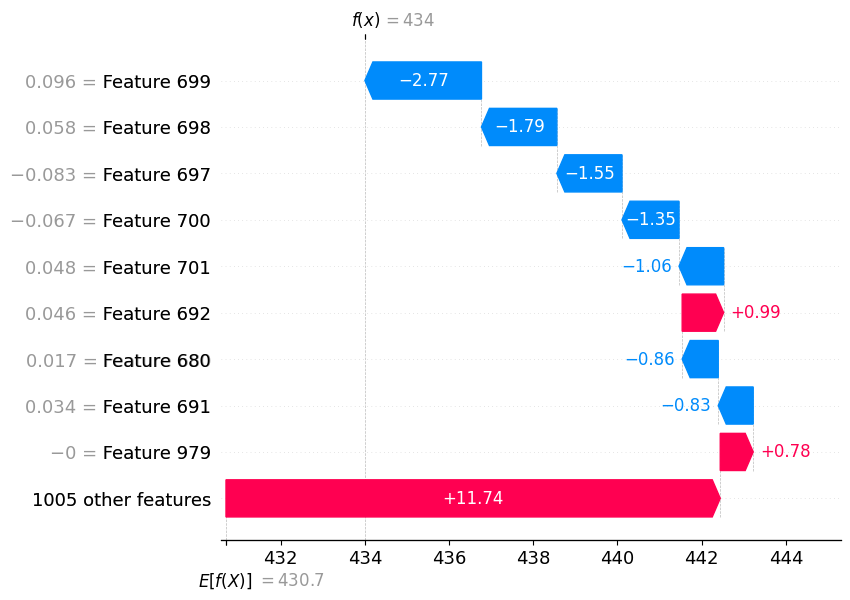

In [10]:
shap.plots.waterfall(shap_values[0])
#plt.savefig("shap_waterfall.svg",dpi=700) #.png,.pdf will also support here
plt.show()